In [2]:
import scanpy as sc
import json
import scvi_v2
import flax.linen as nn

import matplotlib.pyplot as plt
import scib_metrics

In [33]:
from scib_metrics import kbet, silhouette_batch
from scib_metrics.benchmark import Benchmarker, BioConservation, BatchCorrection

In [4]:
# adata = sc.read_h5ad("/data1/scvi-v2-reproducibility/results/aws_pipeline/data/haniffa.preprocessed.h5ad")
adata = sc.read_h5ad("/home/justin/ghrepos/scvi-v2-reproducibility/results/aws_pipeline/data/haniffasubset.preprocessed.h5ad")
sc.pp.subsample(adata, n_obs=50000)
adata

with open("/home/justin/ghrepos/scvi-v2-reproducibility/conf/datasets/haniffasubset.json", 'r') as file:
    config_in = json.load(file)

train_kwargs = config_in["scviv2_train_kwargs"]

train_kwargs= {
    'max_epochs': 400,
    'batch_size': 1024,
    'early_stopping': True,
    'early_stopping_patience': 30,
    'early_stopping_monitor': "validation_loss",
    'check_val_every_n_epoch': 1,
    'plan_kwargs': {'n_epochs_kl_warmup': 15, "lr": 1e-3}
}

scvi_v2.MrVI.setup_anndata(adata, batch_key=config_in["batch_key"], sample_key=config_in["sample_key"])

## Model training

### HD

In [5]:
model_mlp = scvi_v2.MrVI(
    adata, 
    **{
        "qz_nn_flavor": "mlp",
        # "px_nn_flavor": "attention",
        "qz_kwargs": {"use_map": False, "stop_gradients": True},
        # "px_kwargs": {"stop_gradients": True, "stop_gradients_mlp": False, "h_activation": nn.softmax},
        # "learn_z_u_prior_scale": True,
    }
)
model_mlp.train(**train_kwargs)

INFO     Jax module moved to GPU. Note: Pytorch lightning will show GPU is not being used for the Trainer.         


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/justin/miniconda3/envs/run-models/lib/python3.10/site-packages/torch/cuda/__init__.py:146: UserWarning: 
NVIDIA GeForce RTX 3090 with CUDA capability sm_86 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_70.
If you want to use the NVIDIA GeForce RTX 3090 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


Epoch 400/400: 100%|██████████| 400/400 [06:14<00:00,  1.13it/s, v_num=1, train_loss_step=1.34e+3, train_loss_epoch=1.36e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [06:14<00:00,  1.07it/s, v_num=1, train_loss_step=1.34e+3, train_loss_epoch=1.36e+3]


In [21]:
model_smallu_mlp = scvi_v2.MrVI(
    adata, 
    **{
        "qz_nn_flavor": "mlp",
        # "px_nn_flavor": "attention",
        "qz_kwargs": {"use_map": False, "stop_gradients": True},
        "n_latent_u": 10,
        # "px_kwargs": {"stop_gradients": True, "stop_gradients_mlp": False, "h_activation": nn.softmax},
        # "learn_z_u_prior_scale": True,
    }
)
model_smallu_mlp.train(**train_kwargs)

INFO     Jax module moved to GPU. Note: Pytorch lightning will show GPU is not being used for the Trainer.         


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 400/400: 100%|██████████| 400/400 [06:30<00:00,  1.02it/s, v_num=1, train_loss_step=1.54e+3, train_loss_epoch=1.54e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [06:30<00:00,  1.02it/s, v_num=1, train_loss_step=1.54e+3, train_loss_epoch=1.54e+3]


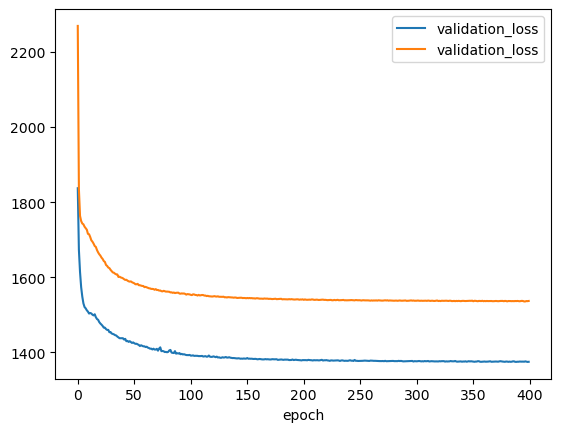

In [24]:
ax = model_mlp.history_["validation_loss"].plot()
ax = model_smallu_mlp.history_["validation_loss"].plot(ax=ax)
# ax = model_linear.history["validation_loss"].plot(ax=ax)
# plt.ylim(1300, 1800)

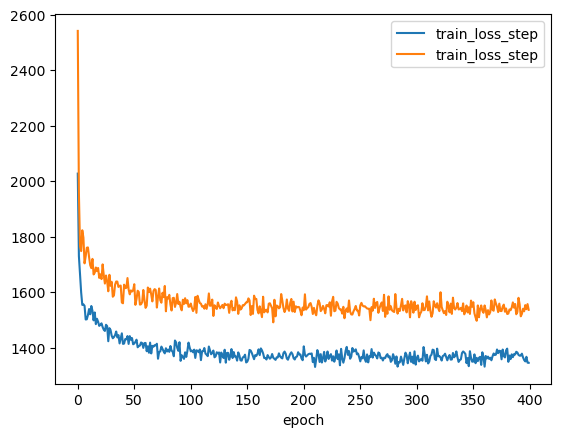

In [25]:
ax = model_mlp.history["train_loss_step"].plot()
ax = model_smallu_mlp.history["train_loss_step"].plot(ax=ax)
# ax = model_linear.history["train_loss_step"].plot(ax=ax)
# plt.ylim(900, 1000)
# plt.xlim(0, 25)

In [26]:
latent_mlp = model_mlp.get_latent_representation()
latent_smallu_mlp = model_smallu_mlp.get_latent_representation()
# latent_sgmlp = model_sgmlp.get_latent_representation()

z_latent_mlp = model_mlp.get_latent_representation(give_z=True)
z_latent_smallu_mlp = model_smallu_mlp.get_latent_representation(give_z=True)
# z_latent_sgmlp = model_sgmlp.get_latent_representation(give_z=True)


100%|██████████| 391/391 [00:01<00:00, 296.59it/s]


### Plot u spaces

/home/justin/miniconda3/envs/run-models/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/justin/miniconda3/envs/run-models/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/justin/miniconda3/envs/run-models/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


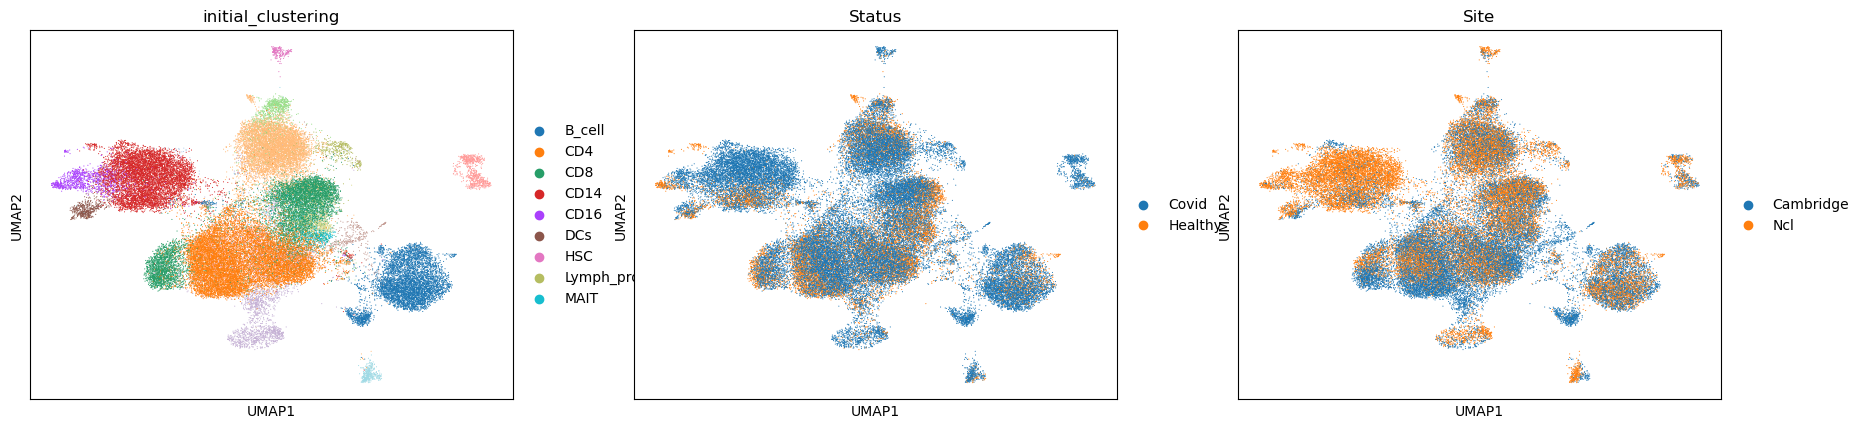

In [27]:
adata.obsm["X_scvi"] = latent_mlp
sc.pp.neighbors(adata, use_rep="X_scvi")
sc.tl.umap(adata)
sc.pl.umap(adata, color=["initial_clustering", "Status", "Site"])

/home/justin/miniconda3/envs/run-models/lib/python3.10/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/justin/miniconda3/envs/run-models/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/justin/miniconda3/envs/run-models/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/justin/miniconda3/envs/run-models/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


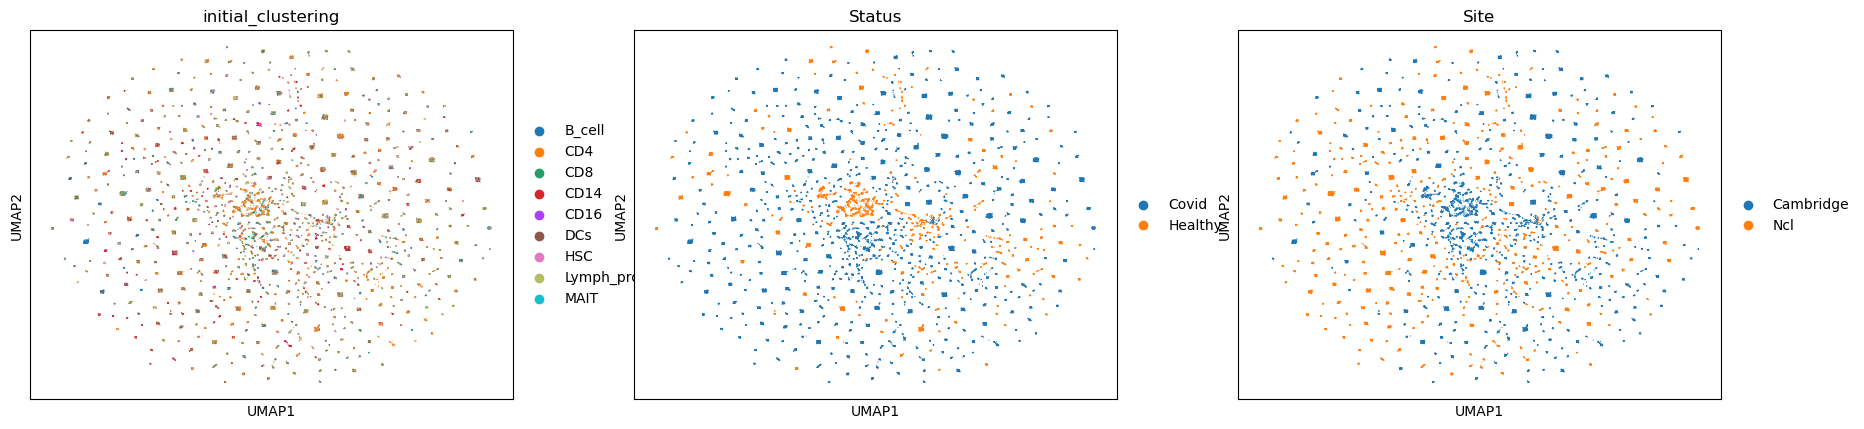

In [28]:
adata.obsm["X_scvi"] = latent_smallu_mlp
sc.pp.neighbors(adata, use_rep="X_scvi")
sc.tl.umap(adata)
sc.pl.umap(adata, color=["initial_clustering", "Status", "Site"])

/home/pierre/miniconda3/envs/run-models/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/pierre/miniconda3/envs/run-models/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/pierre/miniconda3/envs/run-models/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


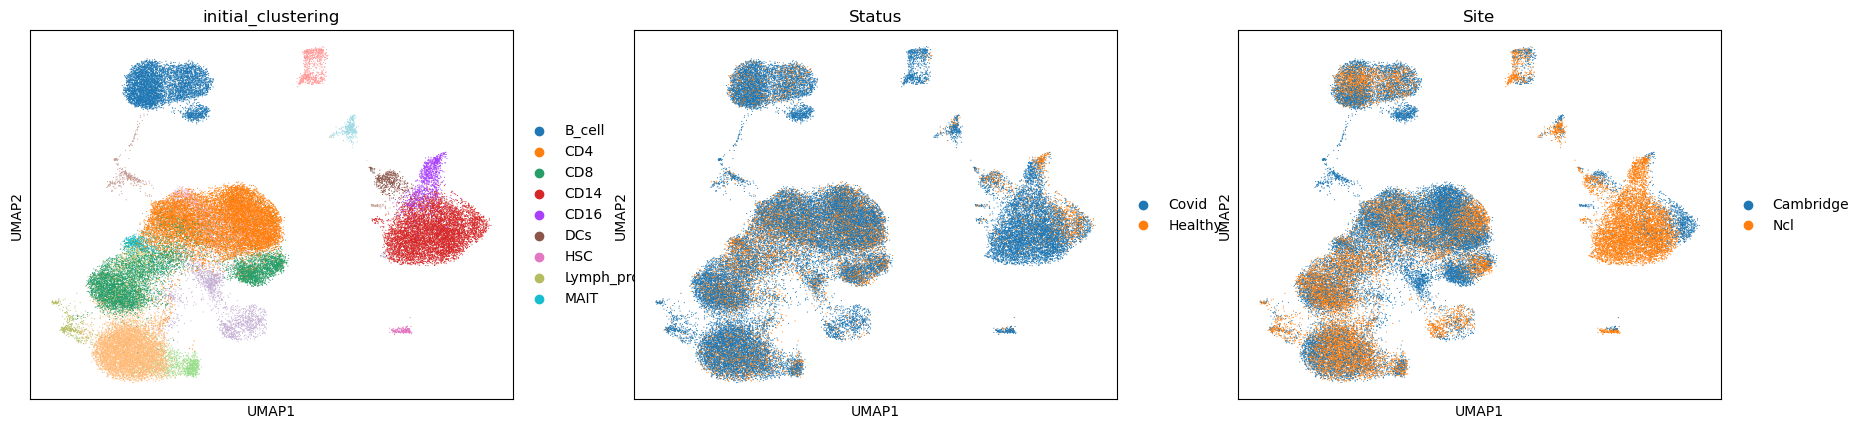

In [48]:
# adata.obsm["X_scvi"] = latent_linear
# sc.pp.neighbors(adata, use_rep="X_scvi")
# sc.tl.umap(adata)
# sc.pl.umap(adata, color=["initial_clustering", "Status", "Site"])

### Plot z spaces

/home/justin/miniconda3/envs/run-models/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/justin/miniconda3/envs/run-models/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/justin/miniconda3/envs/run-models/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


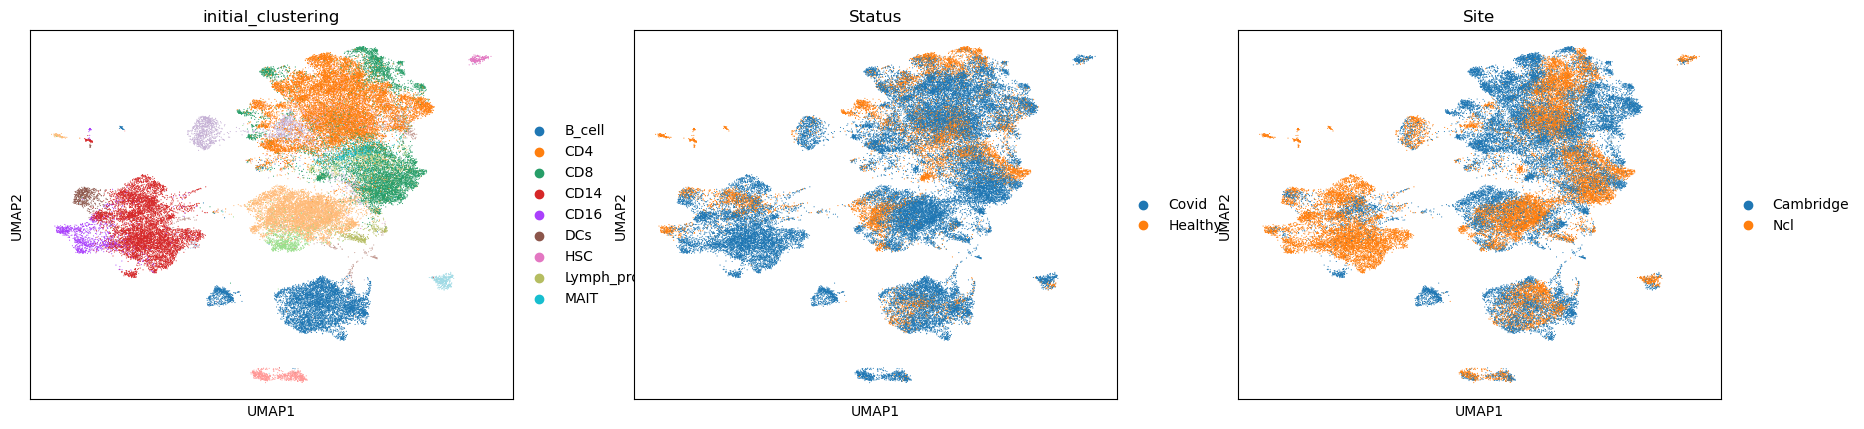

In [29]:
adata.obsm["X_scvi"] = z_latent_mlp
sc.pp.neighbors(adata, use_rep="X_scvi")
sc.tl.umap(adata)
sc.pl.umap(adata, color=["initial_clustering", "Status", "Site"])

/home/pierre/miniconda3/envs/run-models/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/pierre/miniconda3/envs/run-models/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/pierre/miniconda3/envs/run-models/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


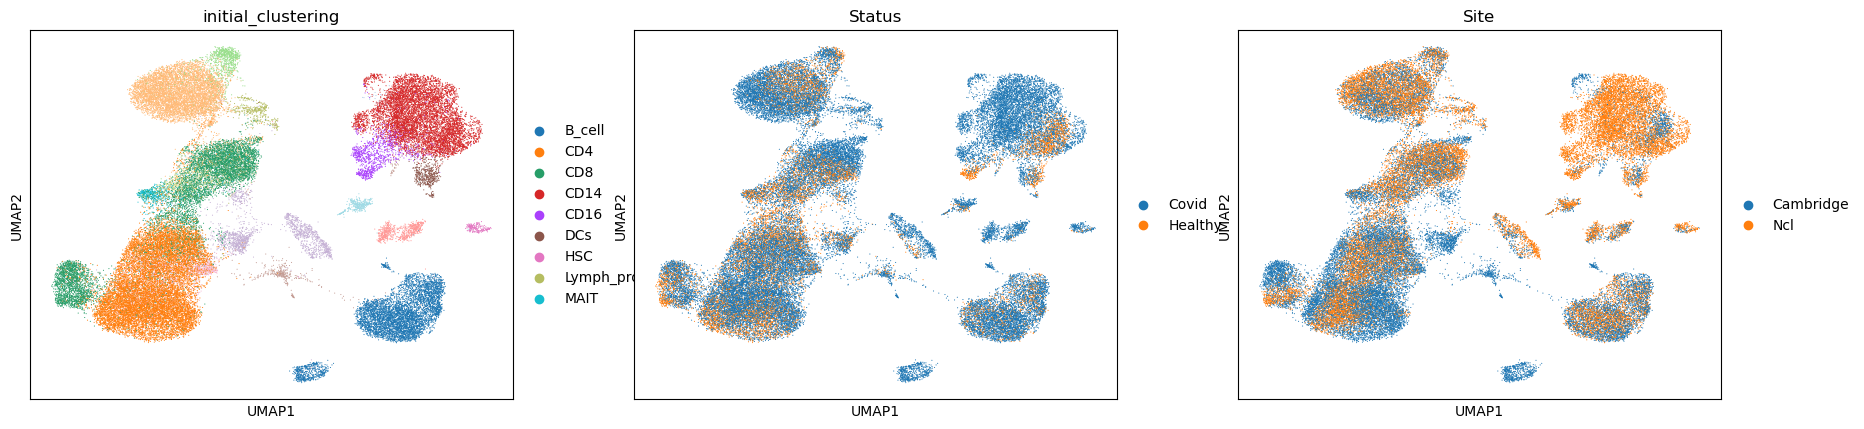

In [16]:
# adata.obsm["X_scvi"] = z_latent_sgmlp
# sc.pp.neighbors(adata, use_rep="X_scvi")
# sc.tl.umap(adata)
# sc.pl.umap(adata, color=["initial_clustering", "Status", "Site"])

/home/pierre/miniconda3/envs/run-models/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/pierre/miniconda3/envs/run-models/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/pierre/miniconda3/envs/run-models/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


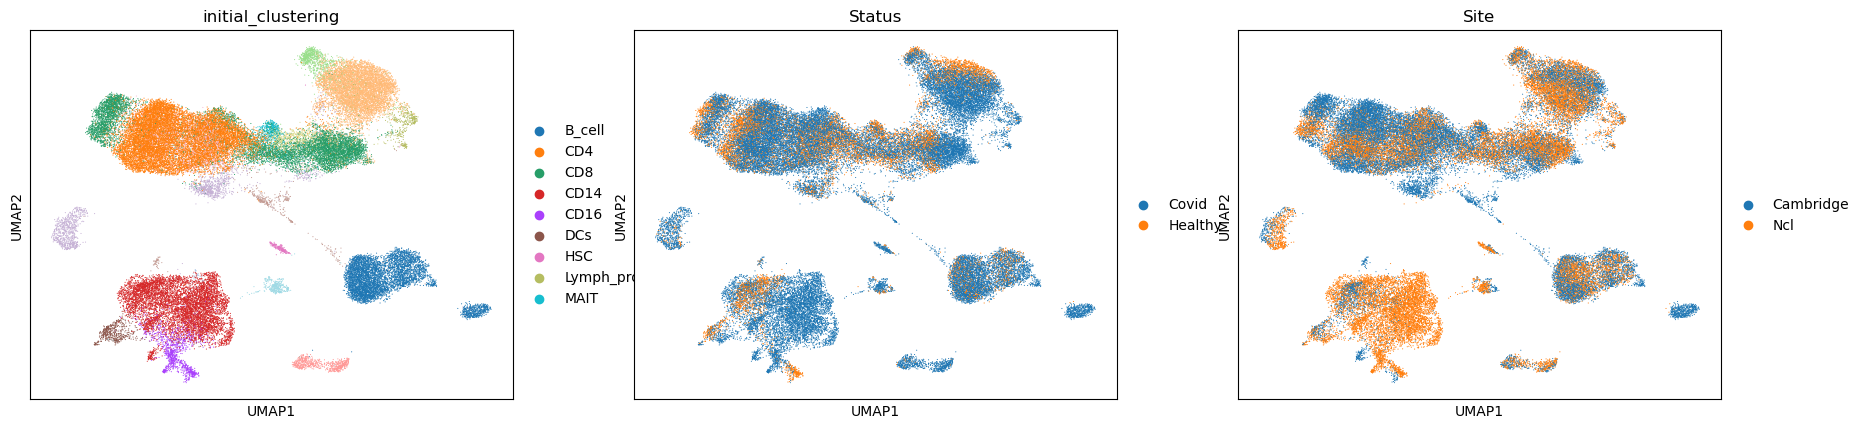

In [17]:
# adata.obsm["X_scvi"] = z_latent_linear
# sc.pp.neighbors(adata, use_rep="X_scvi")
# sc.tl.umap(adata)
# sc.pl.umap(adata, color=["initial_clustering", "Status", "Site"])

## Benchmark

In [30]:
adata.obsm["latent_mlp"] = latent_mlp
adata.obsm["latent_smallu_mlp"] = latent_smallu_mlp
# adata.obsm["latent_linear"] = latent_linear

Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/home/justin/miniconda3/envs/run-models/lib/python3.10/site-packages/scib_metrics/_pcr_comparison.py:49: UserWarning: PCR comparison score is negative, meaning variance contribution increased after integration. Setting to 0.
  warnings.warn(
Embeddings: 100%|██████████| 1/1 [00:02<00:00,  2.70s/it]


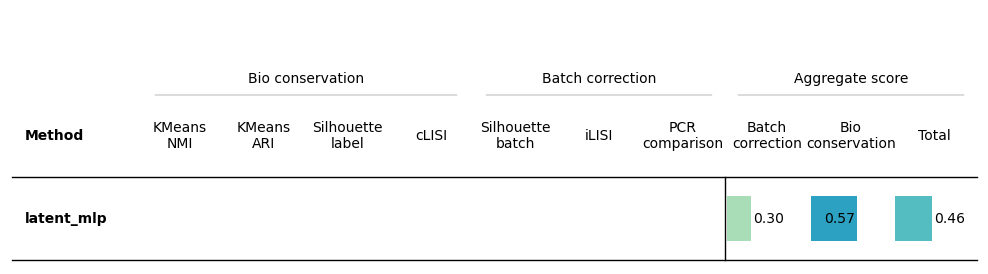

29.35032868385315


In [51]:
import time
start = time.time()
bm = Benchmarker(
    adata,
    batch_key="patient_id",
    label_key="initial_clustering",
    embedding_obsm_keys=["latent_mlp"],
    # pre_integrated_embedding_obsm_key="X_pca",
    bio_conservation_metrics = BioConservation(nmi_ari_cluster_labels_leiden=False, nmi_ari_cluster_labels_kmeans=True, isolated_labels=False, silhouette_label=True, clisi_knn=True),
    batch_correction_metrics = BatchCorrection(silhouette_batch=True, ilisi_knn=True, kbet_per_label=False, graph_connectivity=False, pcr_comparison=True),
    n_jobs=-1,
)

bm.prepare()
bm.benchmark()

bm.plot_results_table(min_max_scale=False)
print(time.time() - start)

### Plot eps

In [20]:
import pandas as pd
import plotnine as p9

In [21]:
eps = z_latent_hd_l - latent_hd_l

In [22]:
plot_df = (
    pd.DataFrame(eps, columns=["D{}".format(i) for i in range(20)])
    .assign(initial_clustering=adata.obs.initial_clustering.values)
)
plot_df

D0        D1        D2        D3        D4        D5        D6  \
0       0.121410 -0.102986  0.038222  0.024695  0.455773  0.181231 -0.135485   
1       0.064610  0.173431 -0.164743 -0.000446 -0.702002  0.029084 -0.163347   
2      -0.067253 -0.343065 -0.025245 -0.211000  0.697354  0.165095 -0.148624   
3       0.242133 -0.247054  0.049260 -0.060402 -0.559114 -0.071161 -0.426849   
4      -0.347134 -0.041219  0.061759  0.098906 -0.062366  0.046020  0.120117   
...          ...       ...       ...       ...       ...       ...       ...   
199995  0.028342 -0.216217 -0.084287 -0.000700 -0.027749 -0.032719 -0.288951   
199996  0.513657 -0.155482 -0.419037 -0.147048  0.005308  0.658123 -0.097215   
199997  0.081753  0.065015  0.047589  0.090035  0.348834  0.141675  0.021814   
199998 -0.251523  0.083850  0.175494 -0.027846 -0.223624 -0.364775  0.120705   
199999 -0.199281  0.171837  0.099737  0.052796 -0.788070 -0.011282  0.123173   

              D7        D8        D9  ...       D11       D12       D13  \
0      -0.473768 -0.014942  0.113295  ...  0.056040  0.232754  0.073890   
1       0.151460  0.141725  0.245611  ... -0.210697  0.492203  0.103279   
2       0.475046 -0.033623 -0.098418  ...  0.206011 -0.174368 -0.000986   
3      -0.016354  0.209824  0.019602  ... -0.137518  0.119458  0.333541   
4       0.781274 -0.141429  0.061208  ... -0.075467  0.376000 -0.516492   
...          ...       ...       ...  ...       ...       ...       ...   
199995  0.714602 -0.055917  0.049305  ...  0.001732  0.316532 -0.099139   
199996  0.417075 -0.077919 -0.122032  ... -0.155434 -0.159351  0.403276   
199997 -0.542524 -0.022531  0.079102  ... -0.011380  0.340599 -0.030047   
199998  0.739820  0.146073  0.344355  ...  0.087771  0.275978 -0.816880   
199999 -0.117131  0.001209 -0.037217  ... -0.045162  0.298438 -0.287767   

             D14       D15       D16       D17       D18       D19  \
0       0.369821 -0.082416  0.148770  0.185432 -0.037986  0.684783   
1       0.301070  0.037226  0.230939  0.152887  0.011102  0.421024   
2      -0.769819 -0.132333  0.224878  0.033597  0.020166  0.104475   
3       0.205508  0.131117 -0.108068  0.140896  0.102466 -0.296240   
4       0.319691 -0.091066  0.123555  0.182139 -0.015755 -0.118559   
...          ...       ...       ...       ...       ...       ...   
199995 -0.253503  0.011191 -0.103736  0.083077 -0.059801  0.012309   
199996  0.178011  0.035866 -0.247053 -0.060733  0.189453 -0.329987   
199997  0.504660 -0.004485  0.051538  0.165469  0.027194  0.564445   
199998  0.976693 -0.175106 -0.030284  0.020253 -0.044172 -0.261453   
199999  0.035006 -0.064972  0.143323  0.090822  0.070255  0.177427   

        initial_clustering  
0                      CD4  
1                  NK_16hi  
2                      CD4  
3                  NK_16hi  
4                      gdT  
...                    ...  
199995                 CD8  
199996                 CD8  
199997                 CD4  
199998                 CD8  
199999             NK_16hi  

[200000 rows x 21 columns]

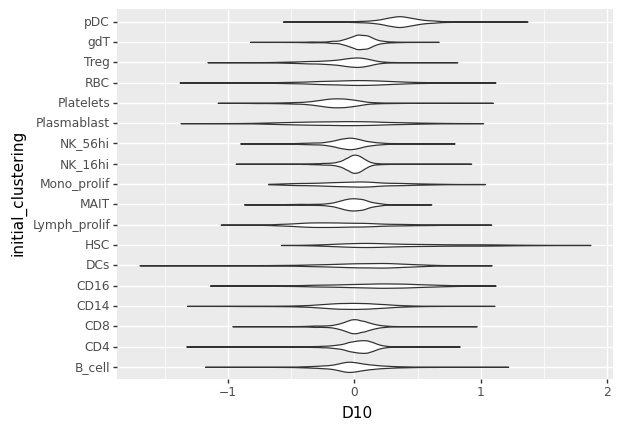

<ggplot: (8780679262266)>

In [23]:
(
    p9.ggplot(plot_df, p9.aes("initial_clustering", "D10"))
    + p9.geom_violin()
    + p9.coord_flip()
)

/home/pierre/miniconda3/envs/run-models/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/home/pierre/miniconda3/envs/run-models/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/home/pierre/miniconda3/envs/run-models/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/home/pierre/miniconda3/envs/run-models/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


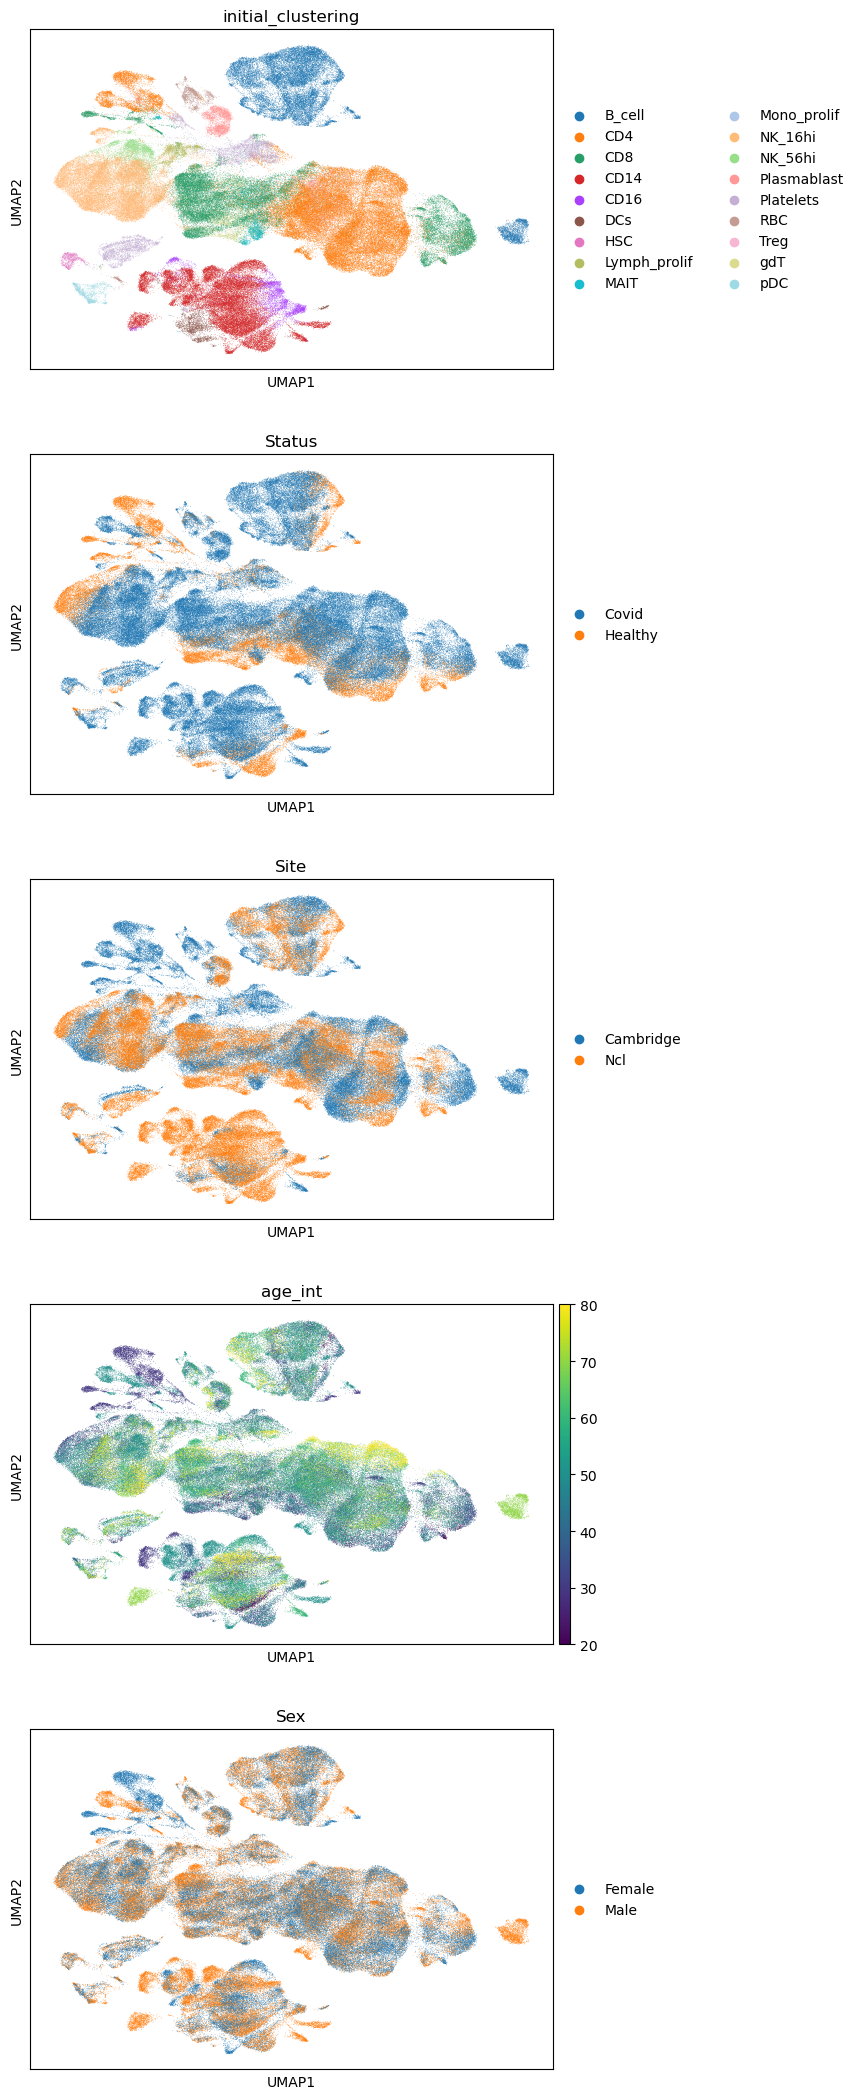

In [24]:
adata.obsm["X_scvi"] = eps
sc.pp.neighbors(adata, use_rep="X_scvi", metric="cosine")
sc.tl.umap(adata)
sc.pl.umap(adata, color=["initial_clustering", "Status", "Site", "age_int", "Sex"], ncols=1)

## DMats

In [25]:
import sys

sys.path.append("./bin")

import seaborn as sns

from tree_utils import hierarchical_clustering, linkage_to_ete
from scipy.cluster.hierarchy import fcluster

In [26]:
cell_normalized_dists = model_hd_l.get_local_sample_distances(
    adata,
    use_mean=True,
    normalize_distances=False,
    keep_cell=False,
    groupby="initial_clustering",
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [02:27<00:00,  5.30it/s]


In [27]:
adata_ = adata

In [29]:
donor_info = adata_.obs.drop_duplicates("patient_id").set_index("patient_id")
color_covid = donor_info["Status"].map({"Covid": "#9E1800", "Healthy": "#019E5D"})
color_sex = donor_info["Sex"].map({"Male": "#4791FF", "Female": "#EBA315"})
color_outcome = donor_info["Outcome"].map({"Home": "#466EB8", "Death": "#B80033", "unknown": "#718085"})
color_site = donor_info["Site"].map({"Ncl": "#eb4034", "Cambridge": "#3452eb"})
color_age = donor_info["Age_interval"].map(
    {
    '(20, 29]': "#f7fcf5",
    '(30, 39]': "#dbf1d6",
    '(40, 49]': "#aedea7",
    '(50, 59]': "#73c476",
    '(60, 69]': "#37a055",
    '(70, 79]': "#0b7734",
    '(80, 89]': "#00441b"
    }
)
color_worst_status = donor_info["Worst_Clinical_Status"].map(
    {
        "Healthy": "#fffefe",
        "LPS": "#fffefe",
        "Asymptomatic": "#ffd4d4",
        "Mild": "#ffaaaa",
        "Moderate": "#ff7e7e",
        "Severe": "#ff5454",
        "Critical": "#ff2a2a",
        "Death": "#000000",
    }
)
donor_info["color_age"] = color_age


colors = pd.concat(
    [
        color_site, color_age, color_covid, color_outcome, color_worst_status
    ], 1
)

/data1/TMP/ipykernel_484233/1081341088.py:32: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.


In [30]:
d = cell_normalized_dists

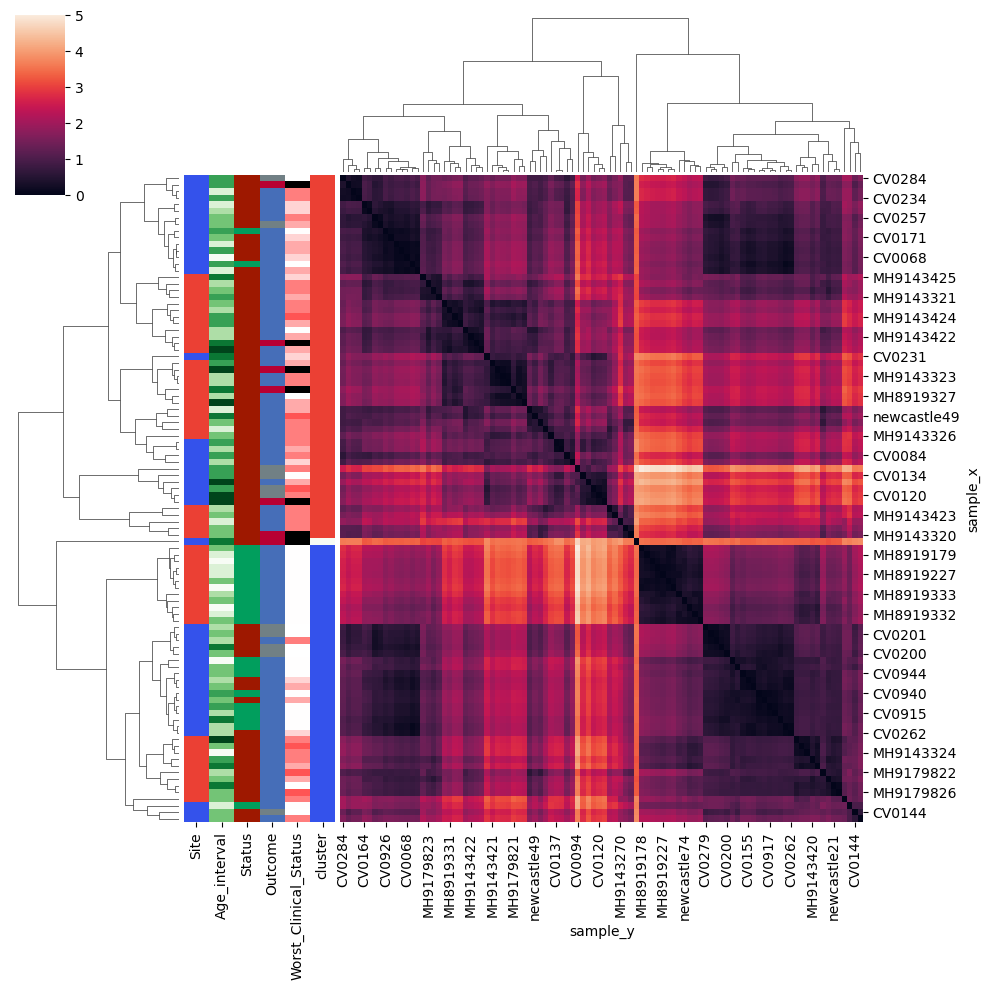

In [31]:
selected_ct = "CD14"

d1 = d.loc[dict(initial_clustering_name=selected_ct)]["initial_clustering"]
d1 = d1.loc[dict(sample_x=donor_info.index)].loc[dict(sample_y=donor_info.index)]
Z = hierarchical_clustering(d1.values, method="complete", return_ete=False)
clusters = fcluster(Z, t=3, criterion="maxclust")
donor_info.loc[:, "cluster"] = clusters
# cluster_colors = donor_info["cluster"].map({1: "#eb4034", 2: "#3452eb", 3: "#f7fcf5"})
colors.loc[:, "cluster"] = donor_info["cluster"].map({1: "#eb4034", 2: "#3452eb", 3: "#f7fcf5"}).values
sns.clustermap(d1.to_pandas(), row_linkage=Z, col_linkage=Z, row_colors=colors)